In [1]:
%load_ext autoreload
%autoreload 2

from rknot.dots import MATRIX_COL_LABELS as ML
from rknot.notebook import *
import matplotlib.pyplot as plt

plt.style.use('rknot_nb')

## Multiple Jurisdictions ##

With our credible model for dynamic transmission at the contact level and our ability to size environments with approriate contact distributions, we can show the true power of **RKnot** in modelling complex scenarios.

We [have previously shown](load.ipynb#Capacity-Restriction) that contact restrictions and social distancing in any one community *should* be effective in eliminating `sars-cov-2` relatively quickly. Across the world, howvever, many states, provinces, and countries, have experienced second and third waves spaced out months apart despite various forms of strict quarantines and lockdowns.

So why haven't they been effective?

In part, this has resulted from the many exceptions made to these restrictions, in particular, [schools remaining open](load.ipynb#Schools) in many jurisdictions.

We must also consider the impact of multiple jurisdictions that have unique characteristics, set policy independently, and, importantly, allow travel between them.

We will focus on two jurisdictions to start, building to four, and building in complexity along the way.

### Mixed ###

To start, we will simply double the size of the environment used in [our dynamic transmission risk models](load.ipynb). Thus,

* n = 20,000 and 4 initial infections
* 8 groups, split evenly into two states: "East State" and "West State"
* the states will be exact reflections of each other: 
    * same size, n = 10,000
    * 2 initial infections each
    * same demographic mix
    * same number of events
* the event structrue for each state is detailed in [Sizing](sizing.ipynb#Complex-Environments) (and imported from a pickled object as per below).
* each state will have its own vbox. The `East State` vbox must be reassigned and the events adjusted to point to the correct groups.

```python
from copy import deepcopy

from rknot import Sim, Chart
from rknot.events import Restriction, Quarantine
from rknot.dots.fhutch import tmr
from rknot.sims import us_w_load_18.events

group1 = dict(name='W0-19', n=2700, n_inf=0, ifr=0.00003, mover=.98)
group2 = dict(name='W20-49', n=4100, n_inf=1, ifr=0.0002, mover=.98)
group3 = dict(name='W50-69', n=2300, n_inf=1, ifr=0.005, mover=.98)
group4 = dict(name='W70+', n=900, n_inf=0, ifr=0.054, mover=.98)
wstate = [group1, group2, group3, group4]

wbox = {'label': 'W Main', 'box': 344}
wevents = deepcopy(us_w_load_18.events)
wrsxns = deepcopy(us_w_load_18.rsxns)

group5 = dict(name='E0-19', n=2700, n_inf=0, ifr=0.00003, mover=.98)
group6 = dict(name='E20-49', n=4100, n_inf=1, ifr=0.0002, mover=.98)
group7 = dict(name='E50-69', n=2300, n_inf=1, ifr=0.005, mover=.98)
group8 = dict(name='E70+', n=900, n_inf=0, ifr=0.054, mover=.98)
estate =  [group5, group6, group7, group8]

ebox = {'label': 'E Main', 'box': 344}
eevents = deepcopy(us_w_load_18.events)

for e in eevents:
    e.groups = [4,5,6,7]
    e.vbox = 1

groups = wstate + estate
vboxes = [wbox, ebox]
events = wevents + eevents

params = {
    'groups': groups, 'density': 1, 'days': 365, 'tmr_curve': tmr, 
    'vboxes': vboxes, 'events': events
}

sim = Sim(**params)
sim.run()
```

Below, we show the arrangement of all of the dots mixed throughout the space. The only difference from the single jurisdiction structure is the presence of two vboxes (instead of one).

In [2]:
from IPython.core.display import display, HTML
from rknot.notebook import animHTML

display(HTML(animHTML('multi/mixed_agg_dots_only')))

On a proportionate basis, this structure is indistinguishable from the n=10,000, 4 group structure used in the viral load simulations. And it should result in the same outbreak curve, on average.

To test, we ran 50 sims for a quick comparison to the base [Events](load.ipynb#Events) structure that we are building from.

In [3]:
from IPython.core.display import display, HTML

import os
from datetime import datetime as dt
import numpy as np

from rknot.helpers import pickload, find_means, find_seconly, find_means_seconly, get_results
from rknot.notebook import curve_table, md
from rknot.helpers import pickload, ShelfHelp

path = 'vids/multi'
slug = 'mixed-pickled'

file_ = os.path.join(path, 'sims', slug)
sims = pickload(file_)

last_date = sorted([dt.strptime(date, '%Y-%m-%d') for date in sims.keys()])[-1]
last_date = last_date.strftime('%Y-%m-%d')
with np.errstate(divide='ignore', invalid='ignore'):
    res = [get_results(sim) for sim in sims[last_date]['sims']]
    res = np.vstack(res)
    m = find_means(res)
    m_gt0 = find_means_seconly(res, m)

file = 'tests/data/sizing_complex'
key = 'complex_1.8_iters_RESULTS_n_inf_2'

args = []
with ShelfHelp(file, key, no_input=True, load=True) as sh:
    _, _, _, _, res1 = sh.values(*args)

with np.errstate(divide='ignore', invalid='ignore'):
    m1 = find_means(res1)
    m1_gt0 = find_means_seconly(res1, m1)

headers = [r'Mixed<br>$R_0$>0', r'Events<br>w Load<br>$R_0$>0'] 

args = [m_gt0, m1_gt0]
sizes = [(find_seconly(res).shape[0], res.shape[0]), (find_seconly(res1).shape[0], res1.shape[0])]
display(HTML(curve_table(headers, args, sizes)))

,Mixed$R_0$>0,Eventsw Load$R_0$>0
"n, $R_0$ > 0",28,68
n,50,250
Peak,23.5%,32.7%
HIT,38.0%,40.6%
Total,53.3%,51.5%
Fatalities,0.32%,0.30%
%>70,51.3%,6.5%
IFR,0.60%,0.60%
Days to Peak,95,74


As expected, we can see above that, on average, the spread results generated in this structure match those of the [Events structure](load.ipynb#Events) from the viral load analysis. Notice, however, that an outbreak ($R_0$ > 0) occured much more frequently: 56% vs. 27%. This is likely a result of the greater number of initial infections (4 vs. 2).

Also notice that the average Peak is lower and Days to Peak higher in our new scenario despite all other metrics being the same.

In the distribution below, we can see that, in this scenario, more simulations result in outbreaks, but when they do, they concentrated around the same level of total infection.

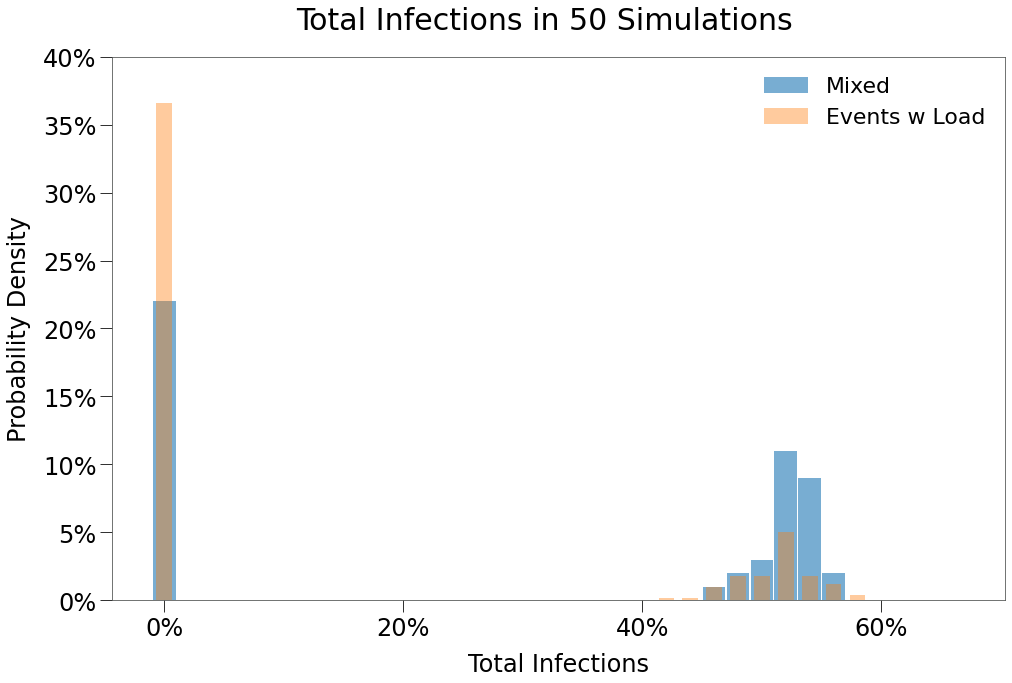

In [4]:
from rknot.notebook import curvehist
savepath = 'vids/multi/imgs/mixed_hist'

title = f'Total Infections in {res.shape[0]} Simulations'
labels = ['Mixed', 'Events w Load']
curvehist([res[:,2], res1[:,2]], title=title, which='tot', widths=[.95, .65], labels=labels, savepath=savepath)

We can see this in the sample simulation below:

In [5]:
from IPython.core.display import display, HTML
from rknot.notebook import animHTML

display(HTML(animHTML('multi/mixed_agg')))

Above, we can see a "wave" effect occuring with two peaks forming, the first around 70 days and second around 115 days. We can seperate the curve among the constituent states to see how each state's curve might have added to the aggregate.

In [6]:
from IPython.core.display import display, HTML
from rknot.notebook import animHTML

display(HTML(animHTML('multi/mixed_peaks')))

From above, we can see that what looked like a single curve and a single outbreak was, in fact, two outbreaks among the two "states", West and East.

Remarkably, the dots from both states are free to mix in the main grid. The separate waves result simply from isolated event spaces where only the largest events (3+ capacity) occur within the state groups.

Next we will show the impact of further isolating the two states.

---
### Borders ###

Now we split the environment into two halves, separating the subjects of the West and East states by a border. 

They cannot interact in any way.

This can be accomplished by simply assign a separate box to the groups in each state, as per below:

```python
for w in wstate:
    w['box'] = {'bounds': [1, 72, 1, 144], 'label': 'West State'}

for e in estate:
    e['box'] = {'bounds': [73, 144, 1, 144], 'label': 'East State'}
    
groups = wstate + estate
params['groups'] = groups

sim = Sim(**params)
sim.run(dotlog=True)
```

This results in the environment shown below:

In [7]:
from IPython.core.display import display, HTML
from rknot.notebook import animHTML

display(HTML(animHTML('multi/split_agg_dots_only')))

We ran 50 simulations to compare with the Mixed environment:

In [44]:
from IPython.core.display import display, HTML

import os
from datetime import datetime as dt
import numpy as np

from rknot.helpers import pickload, find_means, find_seconly, find_means_seconly, get_results
from rknot.notebook import curve_table, md
from rknot.helpers import pickload, ShelfHelp

path = 'vids/multi'
slug = 'split-pickled'

file_ = os.path.join(path, 'sims', slug)
bsims = pickload(file_)

last_date = sorted([dt.strptime(date, '%Y-%m-%d') for date in bsims.keys()])[-1]
last_date = last_date.strftime('%Y-%m-%d')

with np.errstate(divide='ignore', invalid='ignore'):
    r_spl = [get_results(sim) for sim in bsims[last_date]['sims']]
    r_spl = np.vstack(r_spl)
    m_spl = find_means(r_spl)
    m_gt0_spl = find_means_seconly(r_spl, m_spl)

headers = [r'Borders<br>$R_0$>0', r'Mixed<br>$R_0$>0'] 

args = [m_gt0_spl, m_gt0]
sizes = [
    (find_seconly(r_spl).shape[0], r_spl.shape[0]), 
    (find_seconly(res).shape[0], res.shape[0])
]
display(HTML(curve_table(headers, args, sizes)))

,Borders$R_0$>0,Mixed$R_0$>0
"n, $R_0$ > 0",26,28
n,50,50
Peak,19.1%,23.5%
HIT,25.0%,38.0%
Total,31.5%,53.3%
Fatalities,0.20%,0.32%
%>70,50.8%,51.3%
IFR,0.61%,0.60%
Days to Peak,78,95


We can see:
    
+ an outbreak occurs with about the same frequency; likely b/c both environments have the same number of initial infections
+ the size of the outbreaks is significantly lower in the split environment
+ the peaks are significantly lower in the split environment

In [45]:
from IPython.core.display import display, HTML
from rknot.notebook import make_note

title = 'Contact Mix'
body = 'Importantly, doubling the number of subjects does <em>not</em>'
body += ' change the number of contacts. Instead, it changes'
body += ' <em>who</em> is contacted. And so when the environment'
body += ' is split and the contact mix becomes more heterogeneous, spread is curtailed.'
display(HTML(make_note(title, body)))

Again, we see below that the contact distribution of the Borders environment is quite different from the Mixed environment.

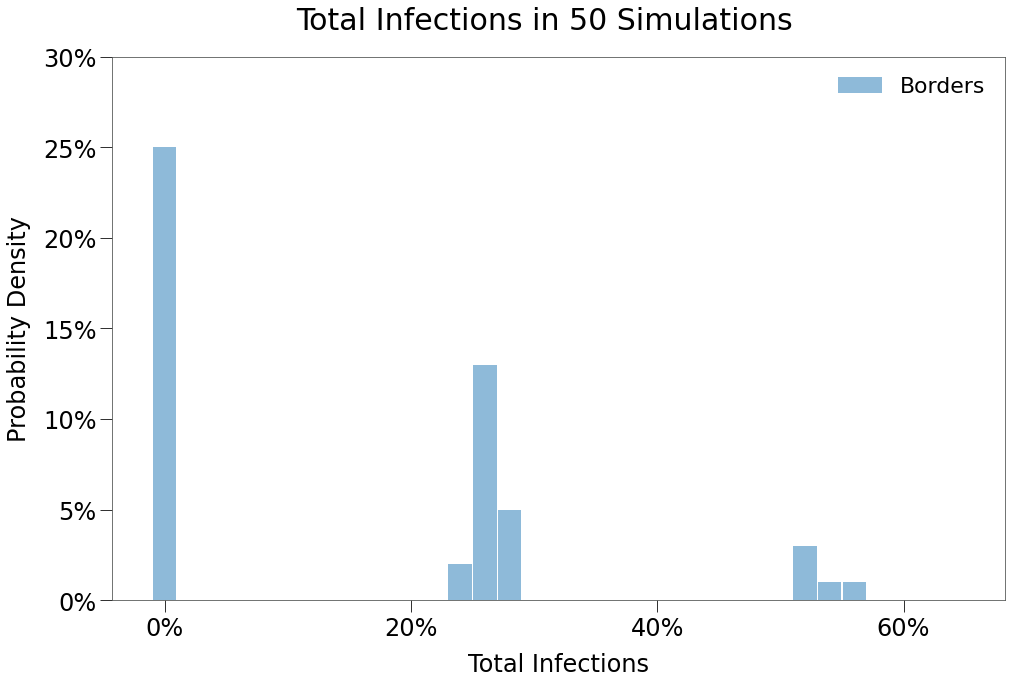

In [46]:
from rknot.notebook import curvehist
savepath = 'vids/multi/borders_hist'

title = f'Total Infections in {res.shape[0]} Simulations'
labels = ['Borders']
curvehist([r_spl[:,2]], title=title, which='tot', widths=[.95, .65], labels=labels, savepath=savepath)

Here, the same number of outbreaks occur, but the virus cannot cross the border so at worst it can only spread amongst half the population. As a result, we see two local peaks form, representing when an outbreak occurs in only one state or in both. 

In a uniform environment, there are only two outcomes: 
    
1. Peak
2. No Peak

When we split the space, there are now 4 distinct possible outcomes:
    
1. No Peaks
2. One Peak: West
3. One Peak: East
4. Two Peaks

We can even get a quick sense for how often these different outcomes might occur, as per below.

In [48]:
# bsims = bsims[last_date]['sims']
westids = np.arange(4)
eastids = np.arange(4, 8)
id_groups = [westids, eastids]

sstack = statestack(bsims, id_groups)
peakset = peak_analysis(sstack, combine=False)
# savepath = peakpie(peakset, path, slug)

In [49]:
display(HTML(peakcomp(peakset, slug)))

As per the piechart above,only 10% of outbreaks resulted in a Double Peak, while more than 40% resulted in an outbreak in either state. Both states were equally likely to have an outbreak on their own.

Below we see a representative simulation that evidences the border separating the two states. We can also see in the grid on the left that the outbreak was entirely isolated to the West state and did *not* seep into the East state at all. This resulted in the shorter, more muted peak.

In [50]:
from IPython.core.display import display, HTML
from rknot.notebook import animHTML

display(HTML(animHTML('multi/split_agg')))

Finally, we also show a typical Double Peak scenario:

In [51]:
from IPython.core.display import display, HTML
from rknot.notebook import animHTML

display(HTML(animHTML('multi/split_double_peaks')))

Here we see both states develop outbreaks *independently* and simultaneously, both with very similar spread curves, peaking just after 60 days and reaching ~17% peaks. The aggregate curve is inline with expectations for a well-mixed environment.

---
### Border Crossings ###

Now that we have controlled borders between isolated states, we can explore the impact of border crossings on spread.

To do so, we will create Travel events allowing subjects from each state to cross over into the other state, as follows:

+ total of 20 crossings per day
    + 10 crossings per day West to East
    + 10 crossings per day East to West
+ each group will have equal likelihood to participate in the crossings

The crossing amount was roughly determined based on international travel statistics out of the US:

+ [~100MM travellers annually *from* the US to other countries](https://travel.trade.gov/view/m-2019-O-001/index.html)
+ [~90MM visits *from* other countries annually](https://www.trade.gov/visitor-arrivals-program-i-94-data)

+ we have assumed 100MM for reach version.

<br>
$$
\\
\frac{\text{100MM visitors annually}}{\text{330MM actual population}} * 
\frac{\text{10,000 pop}}{\text{state}} = \frac{\text{3,031 sim visitors annually}}{\text{state}}
\\\frac{\text{3,031 sim visitors}}{\text{365 days}} = \textit{9 visitors } \text{per day per state}
$$

To do this, we will create 8 random locations for each event (within the each state's box), then assign them to our 8 travel events.

```python
from rknot.events import Travel

xs = np.random.randint(19, 120, size=4)
ys = np.random.randint(20, 120, size=4)
w_locs = np.vstack((xs, ys)).T

xs = np.random.randint(74, 120, size=4)
ys = np.random.randint(10, 120, size=4)
e_locs = np.vstack((xs, ys)).T

crosses = []
for i in range(9):
    crosses += [Travel(name=f'WtoE_{i}', xy=w_locs[i], start_tick=1,
        groups=[0,1,2,3], capacity=1, duration=1, recurring=1
    )]
    crosses += [Travel(
        name=f'EtoW_{i}', xy=e_locs[i], start_tick=1,
        groups=[4,5,6,7], capacity=1, duration=1, recurring=1
    )]
params['events'] += crosses
```

The results of 50 simulations are shown below:

In [52]:
from IPython.core.display import display, HTML

import os
from datetime import datetime as dt
import numpy as np

from rknot.helpers import pickload, find_means, find_seconly, find_means_seconly, get_results
from rknot.notebook import curve_table, md
from rknot.helpers import pickload, ShelfHelp

path = 'vids/multi'
slug = 'border_crossing-pickled'

file_ = os.path.join(path, 'sims', slug)
sims = pickload(file_)

last_date = sorted([dt.strptime(date, '%Y-%m-%d') for date in sims.keys()])[-1]
last_date = last_date.strftime('%Y-%m-%d')

with np.errstate(divide='ignore', invalid='ignore'):
    r_x = [get_results(sim) for sim in sims[last_date]['sims']]

    r_x = np.vstack(r_x)
    m_x = find_means(r_x)
    m_gt0_x = find_means_seconly(r_x, m_x)

headers = [r'Border<br>Crossings<br>$R_0$>0', r'Borders<br>$R_0$>0'] 

args = [m_gt0_x, m_gt0_spl]
sizes = [
    (find_seconly(r_x).shape[0], r_x.shape[0]), 
    (find_seconly(r_spl).shape[0], r_spl.shape[0])
]
display(HTML(curve_table(headers, args, sizes)))

,BorderCrossings$R_0$>0,Borders$R_0$>0
"n, $R_0$ > 0",17,26
n,50,50
Peak,17.6%,19.1%
HIT,23.5%,25.0%
Total,32.7%,31.5%
Fatalities,0.19%,0.20%
%>70,51.6%,50.8%
IFR,0.55%,0.61%
Days to Peak,78,78


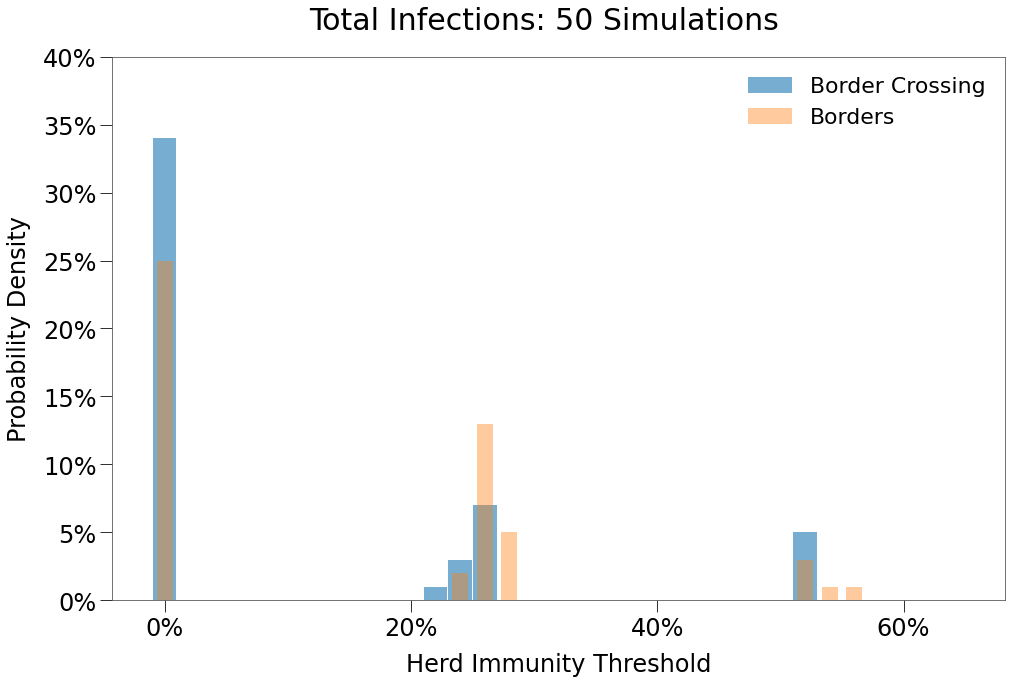

In [58]:
from rknot.notebook import curvehist
savepath = 'vids/multi/crossing_hist'

title = f'Total Infections: {r_x.shape[0]} Simulations'
labels = ['Border Crossing', 'Borders']

curvehist([r_x[:,2], r_spl[:,2]], title=title, which='hit', widths=[.95, .65], labels=labels, savepath=savepath)

We can see the impact of border travel as constructed is limited. The structure actually resulted in a few fewer outbreaks and resulted in similar single and double peak occurences.

In [56]:
# xsims = sims[last_date]['sims']
westids = np.arange(4)
eastids = np.arange(4, 8)
id_groups = [westids, eastids]

sstack = statestack(xsims, id_groups)
peakset = peak_analysis(sstack, combine=False)
# savepath = peakpie(peakset, path, slug)

In [59]:
display(HTML((peakcomp(peakset, slug))))

Below we show a typical Double Peak outcome. In the sim below, the outbreak is almost entirely extinguished and in decline in the East state, but then spread takes hold in the West State and creates a second peak.

In [61]:
from IPython.core.display import display, HTML
from rknot.notebook import animHTML

display(HTML(animHTML('multi/border_crossing_tots')))

---
### Crossings with Event Access ###

The above simulation has major omission. Each traveller only visits the other state for a single tick, only ever land on a single location in the other state's main grid, and so have almost no contact with anyone while travelling.

In reality, travellers often have extended stays of 3/5/7/15/30+ days and, while in the other jurisidiction, they often attend events / have contacts in that jurisdiction like any other local person.

We can mimick this more realistic mixing approach by utilizing the `MultiTravel` event object. This object also a travel event greater than a single tick and allows any participants to attend events in their new region.

We must also implementing a few changes to the existing events. Each event will now pull participants from its own main grid as well as any box created to support cross border travel into the state.

We assume:

+ 9 visits per day per state, consistent with the prior scenario
+ Respective durations of the 9 visits:
    + 4 visits are for 3 days
    + 3 visits are for 5 days
    + 1 visits is for 7 days
    + 1 visit is for 11 days
    
The code looks like this:

```python
from rknot.events import MultiTravel

for e in params['events']:
    e.groups = np.arange(8)
    if 'W' in e.name:
        e.from_boxes = ['West State', 'EtoW']
        e.no_events = False
    if 'E' in e.name:
        e.from_boxes = ['East State', 'WtoE']
        e.no_events = False
```

With the existing events restructured, we assign each event to locations in their box at random.

```python
n_cross = 9
xs = np.random.randint(19, 120, size=n_cross)
ys = np.random.randint(20, 120, size=n_cross)
w_locs = np.vstack((xs, ys)).T

xs = np.random.randint(74, 120, size=n_cross)
ys = np.random.randint(10, 120, size=n_cross)
e_locs = np.vstack((xs, ys)).T

crosses = []
for i, dur in zip(range(n_cross), (3,3,3,3,5,5,5,7,11)):
    crosses += [MultiTravel(name=f'WtoE_{dur}', xy=e_locs[i], start_tick=1,
        groups=[0,1,2,3], capacity=1, recurring=1, duration=dur
    )]
    crosses += [MultiTravel(
        name=f'EtoW_{dur}', xy=w_locs[i], start_tick=1,
        groups=[4,5,6,7], capacity=1, recurring=1, duration=dur
    )]

params['events'] += crosses
```

50 iterations of the above scenario lead to the following:

In [64]:
from IPython.core.display import display, HTML

import os
from datetime import datetime as dt
import numpy as np

from rknot.helpers import pickload, find_means, find_seconly, find_means_seconly, get_results
from rknot.notebook import curve_table, md
from rknot.helpers import pickload, ShelfHelp

path = 'vids/multi'
slug = 'border_crossing_multi'

file_ = os.path.join(path, 'sims', f'{slug}-pickled')
sims = pickload(file_)

last_date = sorted([dt.strptime(date, '%Y-%m-%d') for date in sims.keys()])[-1]
last_date = last_date.strftime('%Y-%m-%d')

r_xe = [get_results(sim) for sim in sims[last_date]['sims']]

r_xe = np.vstack(r_xe)
m_xe = find_means(r_xe)
m_gt0_xe = find_means_seconly(r_xe, m_xe)

headers = [
    r'Crossings<br>w Events<br>$R_0$>0',
    r'Mixed<br>$R_0$>0',
    r'Crossings<br>$R_0$>0'
] 

args = [m_gt0_xe, m_gt0, m_gt0_x]
sizes = [
    (find_seconly(r_xe).shape[0], r_xe.shape[0]), 
    (find_seconly(res).shape[0], res.shape[0]), 
    (find_seconly(r_x).shape[0], r_x.shape[0])
]
display(HTML(curve_table(headers, args, sizes)))

,Crossingsw Events$R_0$>0,Mixed$R_0$>0,Crossings$R_0$>0
"n, $R_0$ > 0",21,28,17
n,52,50,50
Peak,23.4%,23.5%,17.6%
HIT,35.6%,38.0%,23.5%
Total,51.8%,53.3%,32.7%
Fatalities,0.33%,0.32%,0.19%
%>70,49.3%,51.3%,51.6%
IFR,0.64%,0.60%,0.55%
Days to Peak,86,95,78


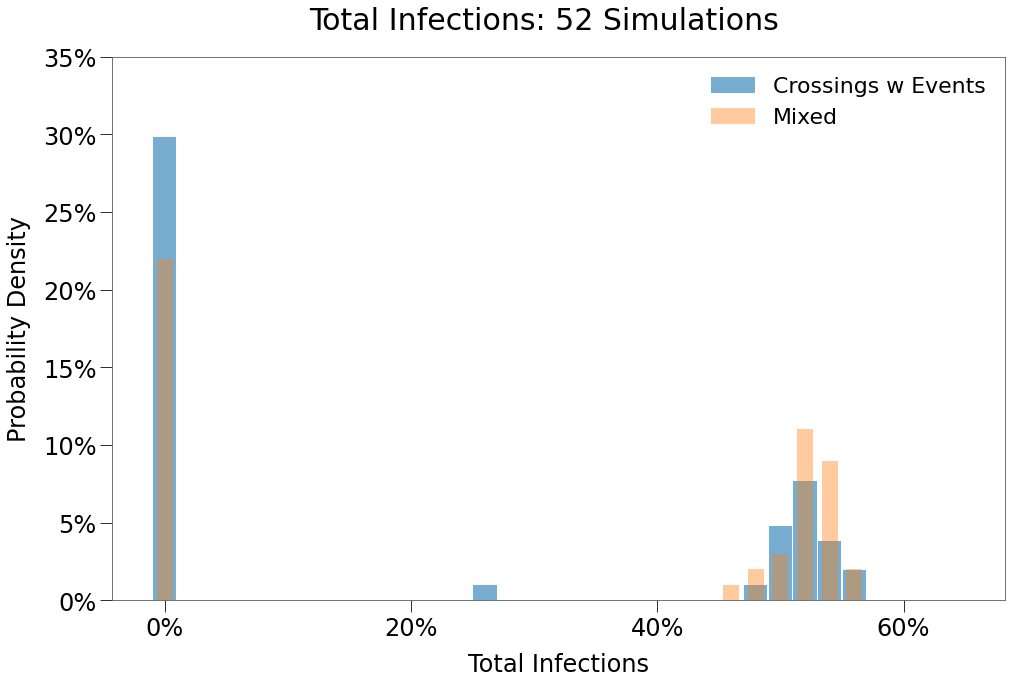

In [65]:
from rknot.notebook import curvehist

savepath = 'vids/multi/crossing_w_eve_hist'

title = f'Total Infections: {r_xe.shape[0]} Simulations'
labels = ['Crossings w Events', 'Mixed']

curvehist([r_xe[:,2], res[:,2]], title=title, which='tot', widths=[.95, .65], labels=labels, savepath=savepath)

Incredibly, we see that just 10 border crossings per day with travellers mixing normally leads to (almost) the same the results as though there were no border at all.

We can also see that the peak distribution has inverted almost completely. Now a Double Peak event is far more likely than a single peak in either state.

In [66]:
xesims = sims[last_date]['sims']
westrng = np.arange(4)
eastrng = np.arange(4, 8)
id_groups = [westrng, eastrng]

sstack = statestack(xesims, id_groups)
peakset = peak_analysis(sstack)
# savepath = peakpie(peakset, path, slug)

In [67]:
from IPython.core.display import display, HTML
display(HTML(peakcomp(peakset, slug)))

We can some additional tools to confirm that mixing between the states was in fact the culprit in increased prevalence of double peaks. The easiest way to determine this to find simulations where a state reach *zero* infections, effectively eradicating the virus in prior scenarios, only to have the virus re-emerge.

This can *ONLY* occur if the virus was transported in from the other state.

In [79]:
inherited = was_inherited(xesims, list(peakset.values())[-1], westids, eastids)
print (inherited)


{0: 'East', 17: 'East', 21: 'West', 43: 'West', 45: 'East'}


In [80]:
text = f'The above tool tells us that in *{len(inherited)}* simulations'
text += ' a state inherited an infection *after* it had already eradicated'
text += ' the virus.'

display(HTML(text))

It also tells us the index position of those states in our grouping of simulations. We will isolate simulation # 21, where West State inherited an outbreak.

We can isolate the specific subject that carried the virus.

In [81]:
sim = xesims[21]
id_groups = [westids, eastids]
west_inf, east_inf = find_group_infs(sim, id_groups, westids, eastids)
westtrim = np.trim_zeros(west_inf, 'fb')

Above is the number of current infections in the West State at each tick during the simulation. We can clearly see an *entire 14-day period* during that simulation where the West State had *zero* infections.

Then, on Tick 44, a single new infection emerges. We can easily isolate which subject was infected.

In [83]:
from rknot.dots import MATRIX_COL_LABELS as ML
erads = np.argwhere(westtrim == 0)
i_erad = erads[-1, 0]

dots = sim.dotlog[i_erad + 1]
westmask = np.isin(dots[:, ML['group_id']], westids)
west = dots[westmask]
west[west[:, ML['is_inf']] == 1]

array([[  5210,      1,      1,      0,      0,      1,      1,  15569,
           109,     18,  15569,    109,     18,      1,      2,      0,
        224729,      5,     98,    100,     20,     44,     -1,     75,
           441,      1,      1]], dtype=int32)

The array above shows the state of subject 5210 as of Tick 44. We can expand the dot matrix to ticks both before and after to get a sense of this subjects movement.

In [84]:
id_new = west[west[:, ML['is_inf']] == 1][0,0]
dottrace = sim.dotlog[i_erad - 4 : i_erad + 4, id_new]
dottrace

array([[  5210,      1,      1,      0,      1,      0,      0,   2585,
            18,    138,   7736,     54,    105,      0,   1515,      1,
         35205,      5,     98,    100,     20,     -1,     -1,     -1,
            -1,      0,      1],
       [  5210,      1,      1,      0,      1,      0,      0,   7736,
            54,    105,   7736,     54,    105,      1,      1,      1,
            -1,      5,     98,    100,     20,     -1,     -1,     -1,
            -1,      1,      1],
       [  5210,      1,      1,      0,      1,      0,      0,   7736,
            54,    105,   7736,     54,    105,      0,      1,      1,
            -1,      5,     98,    100,     20,     -1,     -1,     -1,
            -1,      1,      1],
       [  5210,      1,      1,      0,      1,      0,      0,   7736,
            54,    105,  15569,    109,     18,      0,      2,      1,
        224729,      5,     98,    100,     20,     -1,     -1,     -1,
            -1,      1,      1],
    

We can take the array above and put it in a table for easier viewing:

In [86]:
from IPython.core.display import HTML
display(HTML(tracetable(dottrace)))

id,group_id,is_inf,x,y,homex,homey,event_id
5210,1,0,18,138,54,105,35205
5210,1,0,54,105,54,105,-1
5210,1,0,54,105,54,105,-1
5210,1,0,54,105,109,18,224729
5210,1,0,128,139,109,18,214892
5210,1,1,109,18,109,18,224729
5210,1,1,54,105,54,105,-1
5210,1,1,54,105,54,105,-1


From the table above we can see the following:

+ Subject 5210 was inside the West State box and *not infected* in the days prior to Tick 44.
+ On Tick 42, the subject travelled to East State via 3-day `MultiTravel` event. 
+ On Tick 43, the subject attended an event at location (128, 139), where it was infected.
+ On Tick 45, the subject returned to West State and is at least partly responsible for the re-emergence of the virus in that state.

---
### Care Homes ###

With a few modifications, we can incorporate features of the [Care Home](load.ipynb#Care-Homes) to further increase realism.

Again, we simply double the number of groups, double the number of events, and assign a set of cross border events. In this sim, the `70+G` group in each state is restricted from cross border travel.

```python
import numpy as np
from copy import deepcopy

from rknot import Sim, Chart
from rknot.events import Restriction, Quarantine, Travel, MultiTravel
from rknot.dots.fhutch import tmr
from rknot.sims import us_w_load_18

group1 = dict(name='W0-19', n=2700, n_inf=0, ifr=0.00003, mover=0.982)
group2a = dict(name='W20-49', n=4034, n_inf=1, ifr=0.0002, mover=0.982)
group2b = dict(name='WCHW', n=66, n_inf=0, ifr=0.0002, mover=0.982)
group3 = dict(name='W50-69', n=2300, n_inf=1, ifr=0.005, mover=0.982)
group4a = dict(name='W70+', n=600, n_inf=0, ifr=0.042, mover=0.982)
group4b = dict(name='W70+G', n=300, n_inf=0, ifr=0.0683, mover='local')

wstate = [group1, group2a, group2b, group3, group4a, group4b]

group5 = dict(name='E0-19', n=2700, n_inf=0, ifr=0.00003, mover=0.982)
group6a = dict(name='E20-49', n=4034, n_inf=1, ifr=0.0002, mover=0.982)
group6b = dict(name='ECHW', n=66, n_inf=0, ifr=0.0002, mover=0.982)
group7 = dict(name='E50-69', n=2300, n_inf=1, ifr=0.005, mover=0.982)
group8a = dict(name='E70+', n=600, n_inf=0, ifr=0.042, mover=0.982)
group8b = dict(name='E70+G', n=300, n_inf=0, ifr=0.0683, mover='local')
estate =  [group5, group6a, group6b, group7, group8a, group8b]

for w in wstate:
    w['box'] = {'bounds': [1, 72, 1, 144], 'label': 'West State'}
group4b['box'] = [1,6,1,6]

for e in estate:
    e['box'] = {'bounds': [73, 144, 1, 144], 'label': 'East State'}
group8b['box'] = [139,144,1,6]

groups = wstate + estate

wbox = {'label': 'W Main', 'box': 344}
ebox = {'label': 'E Main', 'box': 344}

wevents = deepcopy(us_w_load_18.events_gated)
eevents = deepcopy(us_w_load_18.events_gated)

# Care Home Events
i_ch = -34
for e in wevents[i_ch:]:
    w.name = f'W_{w.name}'

for e in eevents[i_ch:]:
    e.name = f'E_{e.name}'

# Main Events
for w in wevents[:i_ch]:
    w.name = f'W{e.name}'
    w.from_boxes = ['West State', 'EtoW']
    e.groups = np.arange(8)
    e.no_events = False
    
for e in eevents[:i_ch]:
    e.name = f'W{e.name}'
    e.from_boxes = ['East State', 'WtoE']
    e.vbox = 1
    e.groups = np.arange(8)
    e.no_events = False

groups = wstate + estate
vboxes = [wbox, ebox]
events = wevents + eevents

# Add border crossings
xs = np.random.randint(19, 120, size=4)
ys = np.random.randint(20, 120, size=4)
w_locs = np.vstack((xs, ys)).T

xs = np.random.randint(74, 120, size=4)
ys = np.random.randint(10, 120, size=4)
e_locs = np.vstack((xs, ys)).T

crosses = []
for i, rec in zip(range(4), (3,3,5,5)):
    crosses += [MultiTravel(name=f'WtoE_{i}', xy=e_locs[i], start_tick=1,
        groups=[0,1,2,3,4], capacity=1, recurring=rec
    )]
    crosses += [MultiTravel(
        name=f'EtoW_{i}', xy=w_locs[i], start_tick=1,
        groups=[6,7,8,9,10], capacity=1, recurring=rec
    )]

events_ch += crosses
rsxns = []
quars = []

params_ch = {
    'groups': groups, 'density': 1, 'days': 365, 
    'tmr_curve': tmr, 'vboxes': vboxes, 
    'events': events_ch, 'rsxns': rsxns, 'quars': quars,
}
```

In [101]:
from IPython.core.display import display, HTML

import os
from datetime import datetime as dt
import numpy as np

from rknot.helpers import pickload, find_means, find_seconly, find_means_seconly, get_results
from rknot.notebook import curve_table, md
from rknot.helpers import pickload, ShelfHelp

path = 'vids/multi'
slug = 'carehomes-pickled'
file_ = os.path.join(path, 'sims', slug)
sims = pickload(file_)

last_date = sorted([dt.strptime(date, '%Y-%m-%d') for date in sims.keys()])[-1]
last_date = last_date.strftime('%Y-%m-%d')

r_ch = [get_results(sim) for sim in sims[last_date]['sims']]

r_ch = np.vstack(r_ch)
m_ch = find_means(r_ch)
m_gt0_ch = find_means_seconly(r_ch, m_ch)

headers = [r'Care Homes<br>$R_0$ > 0', r'Crossings<br>$R_0$ > 0'] 

args = [m_gt0_ch, m_gt0_xe]
sizes = [
    (find_seconly(r_ch).shape[0], r_ch.shape[0]), 
    (find_seconly(r_xe).shape[0], r_xe.shape[0])
]
display(HTML(curve_table(headers, args, sizes)))

,Care Homes$R_0$ > 0,Crossings$R_0$ > 0
"n, $R_0$ > 0",29,21
n,60,52
Peak,26.1%,23.4%
HIT,37.6%,35.6%
Total,55.3%,51.8%
Fatalities,0.40%,0.33%
%>70,42.3%,49.3%
IFR,0.73%,0.64%
Days to Peak,84,86


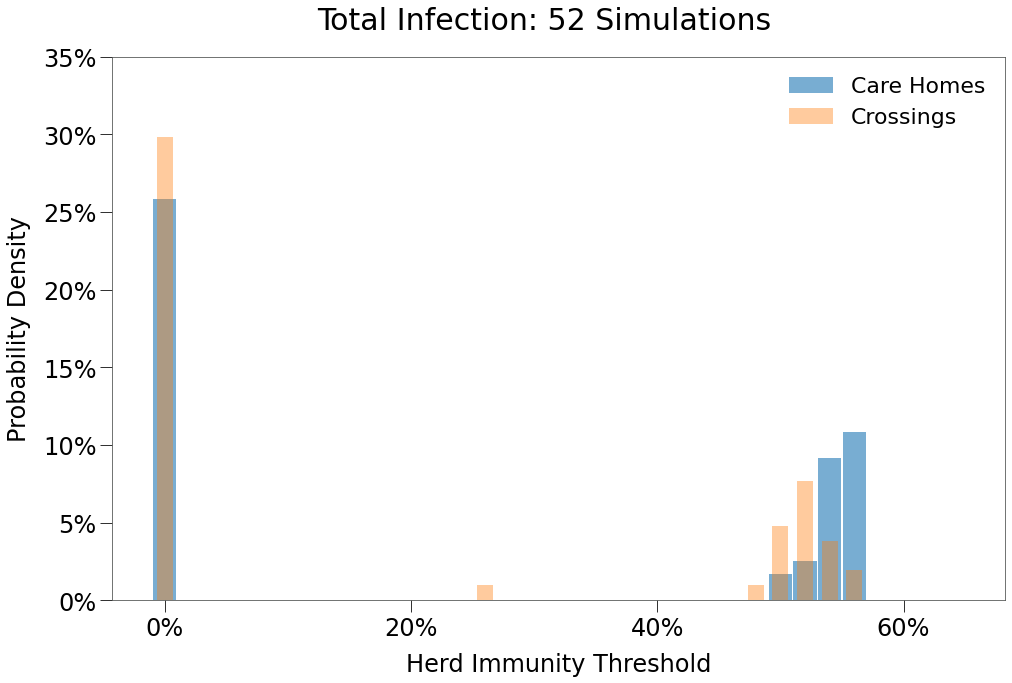

In [102]:
from rknot.notebook import curvehist
savepath = 'vids/multi/mixed_hist'

title = f'Total Infection: {r_xe.shape[0]} Simulations'
labels = ['Care Homes', 'Crossings']

curvehist([r_ch[:,2], r_xe[:,2]], title=title, which='hit', widths=[.95, .65], labels=labels, savepath=savepath)

---
#### Care Homes - 10Max ####

In [103]:
from IPython.core.display import display, HTML

import os
from datetime import datetime as dt
import numpy as np

from rknot.helpers import pickload, find_means, find_seconly, find_means_seconly, get_results
from rknot.notebook import curve_table, md
from rknot.helpers import pickload, ShelfHelp

path = 'vids/multi'
slug = 'carehomes_10Max-pickled'
file_ = os.path.join(path, 'sims', slug)
sims = pickload(file_)

last_date = sorted([dt.strptime(date, '%Y-%m-%d') for date in sims.keys()])[-1]
last_date = last_date.strftime('%Y-%m-%d')

r_ch10 = [get_results(sim) for sim in sims[last_date]['sims']]

r_ch10 = np.vstack(r_ch10)
m_ch10 = find_means(r_ch10)
m_gt0_ch10 = find_means_seconly(r_ch10, m_ch10)

headers = [r'Care Homes<br>10Max<br>$R_0$ > 0', r'Care Homes<br>$R_0$ > 0'] 

args = [m_gt0_ch10, m_gt0_ch]
sizes = [
    (find_seconly(r_ch10).shape[0], r_ch10.shape[0]), 
    (find_seconly(r_ch).shape[0], r_ch.shape[0])
]
display(HTML(curve_table(headers, args, sizes)))

,Care Homes10Max$R_0$ > 0,Care Homes$R_0$ > 0
"n, $R_0$ > 0",16,29
n,48,60
Peak,4.9%,26.1%
HIT,5.4%,37.6%
Total,5.5%,55.3%
Fatalities,0.20%,0.40%
%>70,45.0%,42.3%
IFR,3.60%,0.73%
Days to Peak,52,84


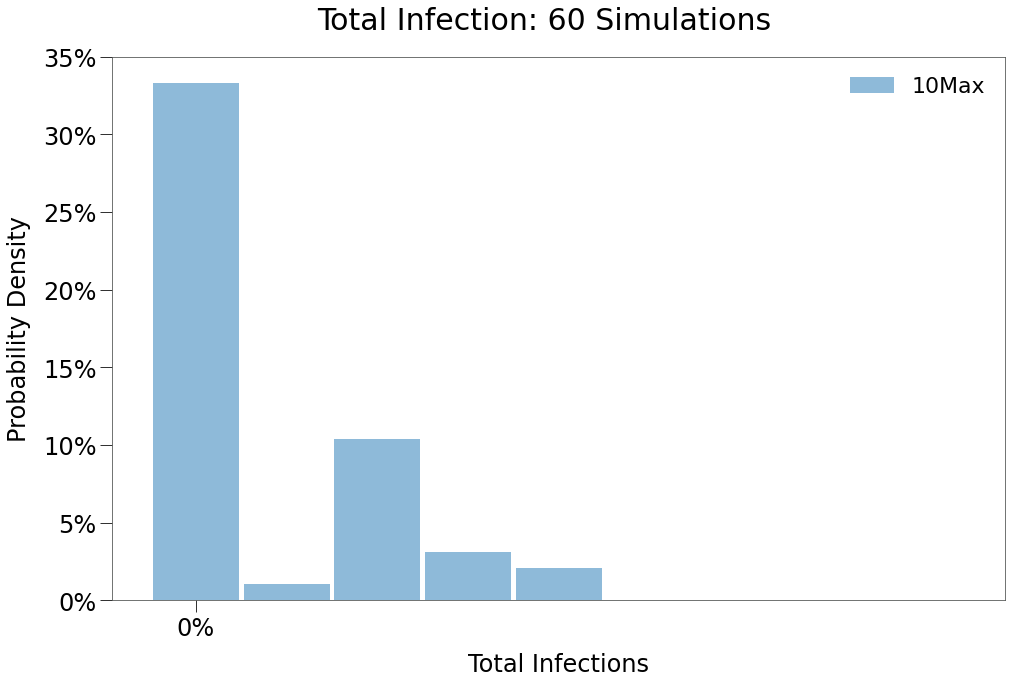

In [113]:
from rknot.notebook import curvehist
savepath = 'vids/multi/uncoord_hist'

title = f'Total Infection: {r_ch.shape[0]} Simulations'
labels = ['10Max']

curvehist([r_ch10[:,2]], title=title, which='tot', widths=[.95], labels=labels, savepath=savepath)

---
#### Care Homes - 25Max ####

In [114]:
from IPython.core.display import display, HTML

import os
from datetime import datetime as dt
import numpy as np

from rknot.helpers import pickload, find_means, find_seconly, find_means_seconly, get_results
from rknot.notebook import curve_table, md
from rknot.helpers import pickload, ShelfHelp

path = 'vids/multi'
slug = 'carehomes_25Max-pickled'
file_ = os.path.join(path, 'sims', slug)
sims = pickload(file_)

last_date = sorted([dt.strptime(date, '%Y-%m-%d') for date in sims.keys()])[-1]
last_date = last_date.strftime('%Y-%m-%d')

r_ch25 = [get_results(sim) for sim in sims[last_date]['sims']]

r_ch25 = np.vstack(r_ch25)
m_ch25 = find_means(r_ch25)
m_gt0_ch25 = find_means_seconly(r_ch25, m_ch25)

headers = [r'Care Homes<br>25Max<br>$R_0$ > 0', r'Care Homes<br>10Max<br>$R_0$ > 0'] 

args = [m_gt0_ch25, m_gt0_ch10]
sizes = [
    (find_seconly(r_ch25).shape[0], r_ch25.shape[0]), 
    (find_seconly(r_ch10).shape[0], r_ch10.shape[0])
]
display(HTML(curve_table(headers, args, sizes)))

,Care Homes25Max$R_0$ > 0,Care Homes10Max$R_0$ > 0
"n, $R_0$ > 0",22,16
n,50,48
Peak,8.1%,4.9%
HIT,9.6%,5.4%
Total,11.3%,5.5%
Fatalities,0.21%,0.20%
%>70,47.2%,45.0%
IFR,2.11%,3.60%
Days to Peak,67,52


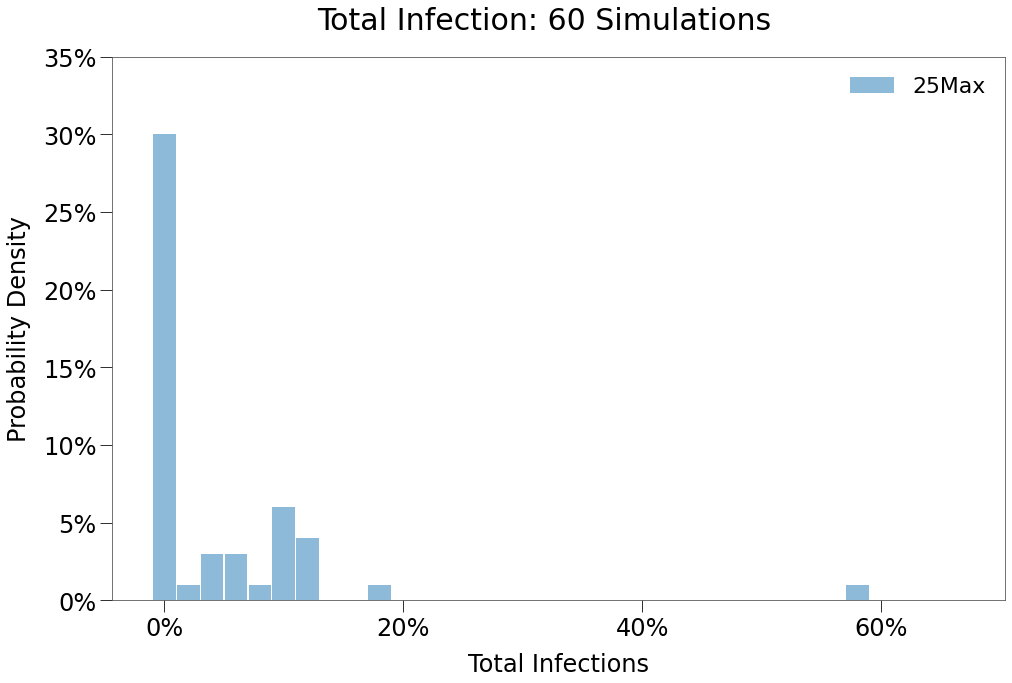

In [116]:
from rknot.notebook import curvehist
savepath = 'vids/multi/uncoord_hist'

title = f'Total Infection: {r_ch.shape[0]} Simulations'
labels = ['25Max']

curvehist([r_ch25[:,2]], title=title, which='tot', widths=[.95], labels=labels, savepath=savepath)

---
#### Care Homes - Uncoordinated ####

In [117]:
from IPython.core.display import display, HTML

import os
from datetime import datetime as dt
import numpy as np

from rknot.helpers import pickload, find_means, find_seconly, find_means_seconly, get_results
from rknot.notebook import curve_table, md
from rknot.helpers import pickload, ShelfHelp

path = 'vids/multi'
slug = 'carehome_async_restrict-pickled'
file_ = os.path.join(path, 'sims', slug)
sims = pickload(file_)

last_date = sorted([dt.strptime(date, '%Y-%m-%d') for date in sims.keys()])[-1]
last_date = last_date.strftime('%Y-%m-%d')

r_chno = [get_results(sim) for sim in sims[last_date]['sims']]

r_chno = np.vstack(r_chno)
m_chno = find_means(r_chno)
m_gt0_chno = find_means_seconly(r_chno, m_chno)

headers = [
    r'Care Homes<br>Uncoordinated<br>$R_0$ > 0', 
    'Care Homes<br>25Max<br>$R_0$ > 0', 
    r'Care Homes<br>10Max<br>$R_0$ > 0'
] 

args = [m_gt0_chno, m_gt0_ch25, m_gt0_ch10]
sizes = [
    (find_seconly(r_chno).shape[0], r_chno.shape[0]), 
    (find_seconly(r_ch25).shape[0], r_ch25.shape[0]),
    (find_seconly(r_ch10).shape[0], r_ch10.shape[0])    
]
display(HTML(curve_table(headers, args, sizes)))

,Care HomesUncoordinated$R_0$ > 0,Care Homes25Max$R_0$ > 0,Care Homes10Max$R_0$ > 0
"n, $R_0$ > 0",22,22,16
n,50,50,48
Peak,7.7%,8.1%,4.9%
HIT,9.8%,9.6%,5.4%
Total,11.8%,11.3%,5.5%
Fatalities,0.22%,0.21%,0.20%
%>70,37.8%,47.2%,45.0%
IFR,2.67%,2.11%,3.60%
Days to Peak,61,67,52


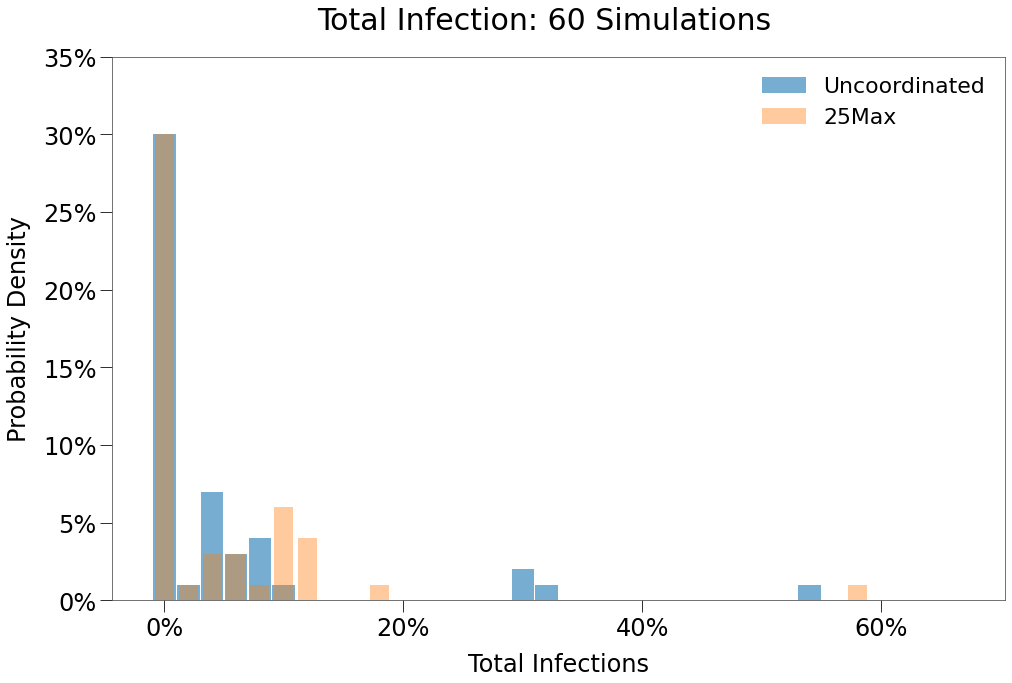

In [118]:
from rknot.notebook import curvehist
savepath = 'vids/multi/uncoord_hist'

title = f'Total Infection: {r_ch.shape[0]} Simulations'
labels = ['Uncoordinated', '25Max']

curvehist([r_chno[:,2], r_ch25[:,2]], title=title, which='tot', widths=[.95, .8, .65], labels=labels, savepath=savepath)

In [120]:
# uncosims = sims[last_date]['sims']
westids = np.arange(4)
eastids = np.arange(4, 8)
id_groups = [westids, eastids]

sstack = statestack(uncosims, id_groups)
peakset = peak_analysis(sstack)
# savepath = peakpie(peakset, path, slug)

In [111]:
from IPython.core.display import display, HTML
display(HTML(peakcomp(peakset, slug)))

---
#### Four Corners ####

In [124]:
from IPython.core.display import display, HTML

import os
from datetime import datetime as dt
import numpy as np

from rknot.helpers import pickload, find_means, find_seconly, find_means_seconly, get_results
from rknot.notebook import curve_table, md
from rknot.helpers import pickload, ShelfHelp

path = 'vids/multi'
slug = '4corners'
file_ = os.path.join(path, slug)
sims = pickload(file_)

last_date = sorted([dt.strptime(date, '%Y-%m-%d') for date in sims.keys()])[-1]
last_date = last_date.strftime('%Y-%m-%d')

r_4 = [get_results(sim) for sim in sims[last_date]['sims']]

r_4 = np.vstack(r_4)
m_4 = find_means(r_4)
m_gt0_4 = find_means_seconly(r_4, m_4)

headers = [r'Four Corners<br>$R_0$', r'Care Homes<br>NoCoord<br>$R_0$'] 

args = [m_gt0_4, m_gt0_ch10]
sizes = [
    (find_seconly(r_4).shape[0], r_4.shape[0]), 
    (find_seconly(r_chno).shape[0], r_chno.shape[0])
]
display(HTML(curve_table(headers, args, sizes)))

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [122]:
from rknot.notebook import move_to_doc_folder
move_to_doc_folder('multi.ipynb')